In [3]:
!pip install transformers
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 88.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 99.9 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.6 MB/s eta 0:00:00


In [4]:
import os
import string
import collections
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam 
from keras.layers import Embedding
from keras.layers import Activation
from keras.layers import GRU,Input,Dense,TimeDistributed
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.models import load_model
from keras.models import Model,Sequential
from nltk.translate.bleu_score import sentence_bleu
from google.colab import drive
from transformers import MBart50TokenizerFast,MBartForConditionalGeneration

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
f = open('/content/drive/MyDrive/Colab Notebooks/deep learning lab/Tamil.txt','r+',encoding = 'utf8')
tamil_input = f.readlines()

In [6]:
f = open('/content/drive/MyDrive/Colab Notebooks/deep learning lab/English.txt','r+',encoding = 'utf8')
english_input = f.readlines()

In [7]:
len(tamil_input)

166871

In [8]:
len(english_input)

166871

In [9]:
x = tamil_input[0:1000]

In [10]:
y = english_input[0:1000]

#Preprocessing

1. Removal of unicode character
2. Removal of extra lines
3. Removal of punctuations
4. Lowercase conversion (only for English)
5. Tokenization
6. Padding

In [11]:
x[0] = x[0].strip('\ufeffMMA')
y[0] = y[0].strip('\ufeffMMA')

In [12]:
exclude = set(string.punctuation)

In [13]:
for i in range(0,len(x)):
  x[i] = x[i].strip('\n')
  x[i] = ''.join(ch for ch in x[i] if ch not in exclude)

In [14]:
for i in range(0,len(y)):
  y[i] = y[i].lower()
  y[i] = y[i].strip('\n')
  y[i] = ''.join(ch for ch in y[i] if ch not in exclude)

In [15]:
print("Tamil Text   :",x[1])
print("English Text :",y[1])

Tamil Text   : சமீபகாலத்தில் சில தகவல்கள் யூலியஸ் ரோசன்பேர்க் ஒரு வித உளவுச்செய்தியை சோவியத் அதிகாரிகளுக்கு இரண்டாம் உலகப்போரின்போது அனுப்பியதில் சம்பந்தப்பட்டு இருந்ததாக வெளிவந்துள்ளன
English Text : information has surfaced in recent years suggesting that julius rosenberg was involved in passing some form of intelligence to soviet officials during the second world war


In [16]:
len(x)

1000

In [17]:
len(y)

1000

In [18]:
tamil_words = []
for i in range(0,len(x)):
  tamil_words.append(x[i].split())  
tamil_words = [j for sub in tamil_words for j in sub]
print("Number of unique Tamil words :",len(set(tamil_words)))

Number of unique Tamil words : 9331


In [19]:
english_words = []
for i in range(0,len(y)):
  english_words.append(y[i].split()) 
english_words = [j for sub in english_words for j in sub]
print("Number of unique English words :",len(set(english_words)))

Number of unique English words : 5632


In [20]:
tamil_vocab = len(set(tamil_words))
eng_vocab = len(set(english_words))

In [21]:
length_tamil = []
for i in range(0,len(x)):
  length_tamil.append(len(x[i].split()))

In [22]:
length_english = []
for i in range(0,len(y)):
  length_english.append(len(y[i].split()))

In [23]:
print("Average number of words per sentence in Tamil   :",sum(length_tamil)/len(length_tamil))
print("Average number of words per sentence in English :",sum(length_english)/len(length_english))

Average number of words per sentence in Tamil   : 15.999
Average number of words per sentence in English : 22.953


In [24]:
print("Maximum number of words per sentence in Tamil   :",max(length_tamil))
print("Maximum number of words per sentence in English :",max(length_english))

Maximum number of words per sentence in Tamil   : 76
Maximum number of words per sentence in English : 112


In [25]:
tamil_words_counter = collections.Counter([word for sentence in x for word in sentence.split()])
english_words_counter = collections.Counter([word for sentence in y for word in sentence.split()])

In [26]:
tamil_words_counter.most_common(10)

[('ஒரு', 181),
 ('மற்றும்', 168),
 ('என்று', 123),
 ('இந்த', 96),
 ('அவர்', 65),
 ('அமெரிக்க', 51),
 ('என்ற', 47),
 ('என', 43),
 ('நான்', 42),
 ('அரசியல்', 39)]

In [27]:
english_words_counter.most_common(10)

[('the', 1881),
 ('of', 892),
 ('and', 801),
 ('to', 656),
 ('in', 524),
 ('a', 395),
 ('that', 294),
 ('is', 234),
 ('for', 222),
 ('on', 168)]

In [28]:
tokenizer = Tokenizer()

In [29]:
def tokenize(x):
  tokenizer.fit_on_texts(x) 
  return tokenizer.texts_to_sequences(x),tokenizer

In [30]:
tokenizer = Tokenizer()

In [31]:
x[0]

' கட்சியின் துணைத்தலைவர் க்வாஸி ஹுசேன் அகமத் சென்ற மாதம் பின்வருமாறு அறிவித்தார் நாங்கள் தீவிரவாதிகள் அல்ல'

In [32]:
z = (tokenizer.fit_on_texts(x))
z = tokenizer.texts_to_sequences(x)
z[0]

[48, 1967, 1968, 961, 1969, 166, 84, 962, 251, 146, 963, 85]

In [33]:
tam_tokenizer = Tokenizer()
tam_tokenizer.fit_on_texts(x)

In [34]:
eng_tokenizer = Tokenizer()
eng_tokenizer.fit_on_texts(y)

In [35]:
sample_test = tam_tokenizer.texts_to_sequences(['கட்சியின் துணைத்தலைவர் க்வாஸி'])

In [36]:
print(sample_test)

[[48, 1967, 1968]]


In [37]:
text_sentences = ['The quick brown fox jumps over the lazy dog .','By Jove, my quick study of lexicography won a prize .']
text_tokenized,text_tokenizer = tokenize(text_sentences)
print(text_tokenizer.word_index)

{'ஒரு': 1, 'மற்றும்': 2, 'என்று': 3, 'இந்த': 4, 'அவர்': 5, 'அமெரிக்க': 6, 'என்ற': 7, 'என': 8, 'நான்': 9, 'அரசியல்': 10, 'உள்ள': 11, 'இருந்து': 12, 'அந்த': 13, 'அது': 14, 'வேண்டும்': 15, 'ஆனால்': 16, 'கட்சி': 17, 'அவர்கள்': 18, 'என்': 19, 'பல': 20, 'அரசாங்கம்': 21, 'மக்கள்': 22, 'அதன்': 23, 'பற்றி': 24, 'இது': 25, 'இருக்கும்': 26, 'என்றும்': 27, 'கடந்த': 28, 'மேலும்': 29, 'புஷ்': 30, 'எதிராக': 31, 'அவன்': 32, 'போர்': 33, 'என்பது': 34, 'தனது': 35, 'இரண்டு': 36, 'ஈராக்': 37, 'பெரும்': 38, 'உள்ளது': 39, 'இருந்த': 40, 'சமூக': 41, 'சர்வதேச': 42, 'ஆண்டு': 43, 'புதிய': 44, 'ஐரோப்பிய': 45, 'நிர்வாகம்': 46, 'பின்னர்': 47, 'கட்சியின்': 48, 'மீது': 49, 'ஜனநாயக': 50, 'அல்லது': 51, 'பெரிய': 52, 'என்பதை': 53, 'இல்லை': 54, 'பொருளாதார': 55, 'ஜனாதிபதி': 56, 'சோசலிச': 57, 'தொழிலாள': 58, 'மூலம்': 59, 'அமெரிக்கா': 60, 'சில': 61, 'கூறினார்': 62, 'வரும்': 63, 'இரு': 64, 'பற்றிய': 65, 'எந்த': 66, 'அதை': 67, 'இராணுவ': 68, 'தன்': 69, 'முன்னாள்': 70, 'வகையில்': 71, 'தான்': 72, 'மில்லியன்': 73, 'தமது': 74, '

In [38]:
for sample_i,(sent,token_sent) in enumerate(zip(text_sentences,text_tokenized)):
  print("Sequence {} in x".format(sample_i + 1))
  print("Input  : {}".format(sent))
  print("Output : {}".format(token_sent))

Sequence 1 in x
Input  : The quick brown fox jumps over the lazy dog .
Output : [148, 1967, 9332, 9333, 9334, 9335, 148, 9336, 9337]
Sequence 2 in x
Input  : By Jove, my quick study of lexicography won a prize .
Output : [9338, 9339, 9340, 1967, 9341, 297, 9342, 9343, 946, 9344]


In [39]:
def pad(x,length = None):
  return pad_sequences(x,maxlen = length,padding = 'post')

In [40]:
test_pad = pad(text_tokenized)

In [41]:
for sample_i,(token_sent,pad_sent) in enumerate(zip(text_tokenized,test_pad)):
  print('Sequence {} in x'.format(sample_i + 1))
  print('Input  : {}'.format(np.array(token_sent)))
  print('Output : {}'.format(pad_sent))

Sequence 1 in x
Input  : [ 148 1967 9332 9333 9334 9335  148 9336 9337]
Output : [ 148 1967 9332 9333 9334 9335  148 9336 9337    0]
Sequence 2 in x
Input  : [9338 9339 9340 1967 9341  297 9342 9343  946 9344]
Output : [9338 9339 9340 1967 9341  297 9342 9343  946 9344]


In [42]:
def preprocess(x,y):
  print(x,"\n")
  preprocess_x,x_tk = tokenize(x)
  preprocess_y,y_tk = tokenize(y)
  preprocess_x = pad(preprocess_x)
  preprocess_y = pad(preprocess_y)
  print("Shape before :",preprocess_y.shape)
  preprocess_y = preprocess_y.reshape(*preprocess_y.shape,1)
  print("Shape after  :",preprocess_y.shape)
  print("\n",x_tk)
  print("\n",preprocess_x)
  return preprocess_x,preprocess_y,x_tk,y_tk

In [43]:
preprocess_x,x_tk = tokenize(x)
preprocess_x = pad(preprocess_x)

In [44]:
preprocess_x.shape

(1000, 76)

In [45]:
preproc_tamil_sentences,preproc_english_sentences,tamil_tokenizer,english_tokenizer = preprocess(x,y)

[' கட்சியின் துணைத்தலைவர் க்வாஸி ஹுசேன் அகமத் சென்ற மாதம் பின்வருமாறு அறிவித்தார் நாங்கள் தீவிரவாதிகள் அல்ல', 'சமீபகாலத்தில் சில தகவல்கள் யூலியஸ் ரோசன்பேர்க் ஒரு வித உளவுச்செய்தியை சோவியத் அதிகாரிகளுக்கு இரண்டாம் உலகப்போரின்போது அனுப்பியதில் சம்பந்தப்பட்டு இருந்ததாக வெளிவந்துள்ளன', 'ஆசோர் சாதோக்கைப் பெற்றான் சாதோக்கு ஆகீமைப் பெற்றான் ஆகீம் எலியூதைப் பெற்றான்', 'என்ன நடக்கிறது என்பது தமக்கு தெரியும் என்றும் ஆனால் தம்மால் எதுவும் செய்யமுடியாது என்றும் கடிதம் எழுதியிருந்தார்', 'நான் தப்பிநடந்தது மெய்யானாலும் என் தப்பிதம் என்னோடேதான் இருக்கிறது', 'டால்ரிம்பிளினுடைய அறிவுஜீவித் தொடுவானத்திற்கு அப்பால் எவ்வளவோ தொலைவில் இருந்தன', 'இந்த அமைப்புக்களில் British Tamil Forum La Maison du Tamil Eelam France the Canadian Tamil Congress Swiss Tamil Forumspan langDE ஆகியவை அடங்கும்', 'தனது மனைவி மகளுடன் அஞ்சாதே படத்தை ரசித்தார் விஜய்', 'முஷாரப் மற்றும் வாஜ்பாயி இருவருமே அவர்களது நாடுகளில் அவர்களின் ஆட்சிக்கு எதிரான மக்களின் கவனத்தைத் திசைதிருப்பவும் அவர்களது ஆட்டம் கண்டுள்ள நிர்வாகங்களை தக்கவைக

In [46]:
def logits_to_text(logits,tokenizer):
  index_to_words = {id : word for word,id in tokenizer.word_index.items()}
  index_to_words[0] = "<PAD>"
  return ' '.join([index_to_words[prediction] for prediction in np.argmax(logits,1)])

In [47]:
print("Tamil sentences shape   :",preproc_tamil_sentences.shape)
print("English sentences shape :",preproc_english_sentences.shape)
print("Output sequence length  :",preproc_english_sentences.shape[1])

Tamil sentences shape   : (1000, 76)
English sentences shape : (1000, 112, 1)
Output sequence length  : 112


In [48]:
preproc_tamil_sentences

array([[  48, 1967, 1968, ...,    0,    0,    0],
       [1970,   61,  965, ...,    0,    0,    0],
       [1981, 1982,  423, ...,    0,    0,    0],
       ...,
       [  30,  392,  214, ...,    0,    0,    0],
       [9312,  183, 9313, ...,    0,    0,    0],
       [ 210,   31,  286, ...,    0,    0,    0]], dtype=int32)

In [49]:
tmp_x = pad(preproc_tamil_sentences,preproc_english_sentences.shape[1])
tmp_x = tmp_x.reshape((-1,preproc_english_sentences.shape[-2],1))

In [50]:
tmp_x.shape

(1000, 112, 1)

#GRU

In [51]:
def gru_model(input_shape,output_sequence_length,tamil_vocab_size,english_vocab_size,learning_rate = 0.1):
  model_1 = Sequential()
  model_1.add(GRU(128,dropout = 0.1,input_shape = input_shape[1:],return_sequences = True))
  model_1.add(TimeDistributed(Dense(english_vocab_size,activation = 'softmax')))
  model_1.summary()
  model_1.compile(loss = sparse_categorical_crossentropy,optimizer = Adam(learning_rate),metrics = ['accuracy'])
  return model_1

In [52]:
gru = gru_model(tmp_x.shape,preproc_english_sentences.shape[1],eng_vocab + 1,tamil_vocab + 1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 112, 128)          50304     
                                                                 
 time_distributed (TimeDistr  (None, 112, 9332)        1203828   
 ibuted)                                                         
                                                                 
Total params: 1,254,132
Trainable params: 1,254,132
Non-trainable params: 0
_________________________________________________________________


In [53]:

gru_rnn = gru.fit(tmp_x,preproc_english_sentences,batch_size = 100,epochs = 20,validation_split = 0.2)

Epoch 1/20
8/8 [==============================] - 12s 206ms/step - loss: nan - accuracy: 0.7687 - val_loss: nan - val_accuracy: 0.7913
Epoch 2/20
8/8 [==============================] - 1s 134ms/step - loss: nan - accuracy: 0.7960 - val_loss: nan - val_accuracy: 0.7913
Epoch 3/20
8/8 [==============================] - 1s 138ms/step - loss: nan - accuracy: 0.7960 - val_loss: nan - val_accuracy: 0.7913
Epoch 4/20
8/8 [==============================] - 1s 133ms/step - loss: nan - accuracy: 0.7960 - val_loss: nan - val_accuracy: 0.7913
Epoch 5/20
8/8 [==============================] - 1s 139ms/step - loss: nan - accuracy: 0.7960 - val_loss: nan - val_accuracy: 0.7913
Epoch 6/20
8/8 [==============================] - 1s 139ms/step - loss: nan - accuracy: 0.7960 - val_loss: nan - val_accuracy: 0.7913
Epoch 7/20
8/8 [==============================] - 1s 141ms/step - loss: nan - accuracy: 0.7960 - val_loss: nan - val_accuracy: 0.7913
Epoch 8/20
8/8 [==============================] - 1s 141ms/st

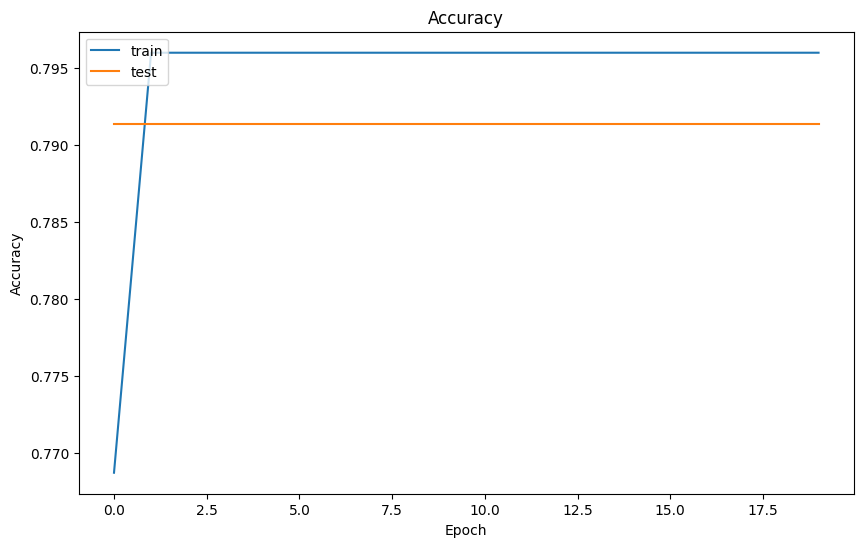

In [54]:
plt.figure(figsize = (10,6))
plt.plot(gru_rnn.history['accuracy'])
plt.plot(gru_rnn.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','test'],loc = 'upper left')
plt.show()

In [55]:
score = gru.evaluate(tmp_x,preproc_english_sentences,verbose = 0)

In [56]:
print("Training Accurancy :",score[1])

Training Accurancy : 0.7950624823570251


In [57]:
x[15]

'வெளிநாட்டுக்கு ஷூட்டிங் கிளம்பும்வரை நன்றாகத்தான் இருந்தார் ஆபிரஹாம்'

In [58]:
y[15]

'before his voyage overseas for shooting he was perfectly alright'

In [59]:
print(logits_to_text(gru.predict(tmp_x[:25])[15],english_tokenizer))

1/1 [==============================] - 0s 446ms/step
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


#LSTM

In [60]:
def lstm_model(input_shape,output_sequence_length,tamil_vocab_size,english_vocab_size,learning_rate = 0.1):
  model_2 = Sequential()
  model_2.add(Embedding(max(tamil_vocab_size,english_vocab_size),128,input_length = output_sequence_length))
  model_2.add(LSTM(128,dropout = 0.1,return_sequences = True))
  model_2.add(Dense(english_vocab_size,activation = 'softmax'))
  model_2.summary()
  model_2.compile(loss = sparse_categorical_crossentropy,optimizer = Adam(learning_rate),metrics = ['accuracy'])
  return model_2

In [61]:
tmp_x = pad(preproc_tamil_sentences,preproc_english_sentences.shape[1])

In [62]:
tmp_x.shape

(1000, 112)

In [63]:
lstm = lstm_model(tmp_x.shape,preproc_english_sentences.shape[1],len(tamil_tokenizer.word_index) + 1,len(english_tokenizer.word_index) + 1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 112, 128)          1876608   
                                                                 
 lstm (LSTM)                 (None, 112, 128)          131584    
                                                                 
 dense_1 (Dense)             (None, 112, 14661)        1891269   
                                                                 
Total params: 3,899,461
Trainable params: 3,899,461
Non-trainable params: 0
_________________________________________________________________


In [64]:
lstm_rnn = lstm.fit(tmp_x,preproc_english_sentences,batch_size = 100,epochs = 20,validation_split = 0.2)

Epoch 1/20
8/8 [==============================] - 6s 395ms/step - loss: 5.0148 - accuracy: 0.6974 - val_loss: 4.5452 - val_accuracy: 0.7914
Epoch 2/20
8/8 [==============================] - 2s 254ms/step - loss: 3.5486 - accuracy: 0.7885 - val_loss: 3.3519 - val_accuracy: 0.7911
Epoch 3/20
8/8 [==============================] - 2s 286ms/step - loss: 2.3551 - accuracy: 0.7954 - val_loss: 2.3015 - val_accuracy: 0.7945
Epoch 4/20
8/8 [==============================] - 2s 231ms/step - loss: 1.8116 - accuracy: 0.8005 - val_loss: 2.1374 - val_accuracy: 0.7982
Epoch 5/20
8/8 [==============================] - 2s 259ms/step - loss: 1.5929 - accuracy: 0.8026 - val_loss: 2.0738 - val_accuracy: 0.7963
Epoch 6/20
8/8 [==============================] - 3s 400ms/step - loss: 1.4443 - accuracy: 0.8043 - val_loss: 2.0698 - val_accuracy: 0.7974
Epoch 7/20
8/8 [==============================] - 3s 355ms/step - loss: 1.3329 - accuracy: 0.8055 - val_loss: 2.1020 - val_accuracy: 0.7958
Epoch 8/20
8/8 [====

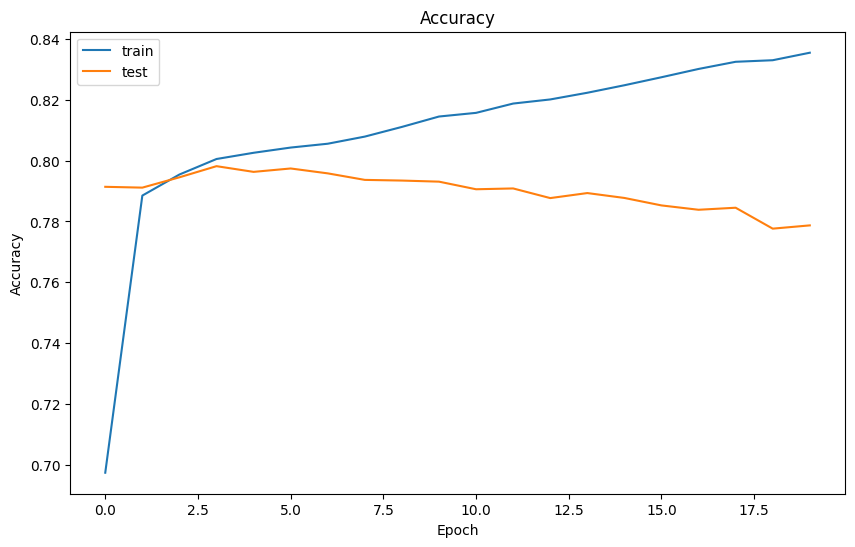

In [65]:
plt.figure(figsize = (10,6))
plt.plot(lstm_rnn.history['accuracy'])
plt.plot(lstm_rnn.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','test'],loc = 'upper left')
plt.show()

In [66]:
score = lstm.evaluate(tmp_x,preproc_english_sentences,verbose = 0)

In [67]:
print("Training Accurancy :",score[1])

Training Accurancy : 0.8359107375144958


In [68]:
x[15]

'வெளிநாட்டுக்கு ஷூட்டிங் கிளம்பும்வரை நன்றாகத்தான் இருந்தார் ஆபிரஹாம்'

In [69]:
y[15]

'before his voyage overseas for shooting he was perfectly alright'

In [70]:
print(logits_to_text(lstm.predict(tmp_x[:25])[15],english_tokenizer))

1/1 [==============================] - 1s 548ms/step
ramanathan lawandorder voyage overseas coalition shooting the alright <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [71]:
tamil_tokenizer.word_index['ஒன்று']
a = []
t = [0] * 74
s = [0] * 74
t[0] = 10
a.append(t)
a.append(s)
a = np.array(a)
a[:1][0]

array([10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0])

#Bidirectional LSTM

In [72]:
def bi_lstm_model(input_shape,output_sequence_length,tamil_vocab_size,english_vocab_size,learning_rate = 0.1):
  model_3 = Sequential()
  model_3.add(Embedding(max(tamil_vocab_size,english_vocab_size),128,input_length = output_sequence_length))
  model_3.add(Bidirectional(LSTM(128,dropout = 0.1,return_sequences = True)))
  model_3.add(Dense(english_vocab_size,activation = 'softmax'))
  model_3.summary()
  model_3.compile(loss = sparse_categorical_crossentropy,optimizer = Adam(learning_rate),metrics = ['accuracy'])
  return model_3

In [73]:
tmp_x = pad(preproc_tamil_sentences,preproc_english_sentences.shape[1])

In [74]:
tmp_x.shape

(1000, 112)

In [75]:
bi_lstm = bi_lstm_model(tmp_x.shape,preproc_english_sentences.shape[1],len(tamil_tokenizer.word_index) + 1,len(english_tokenizer.word_index) + 1)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 112, 128)          1876608   
                                                                 
 bidirectional (Bidirectiona  (None, 112, 256)         263168    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 112, 14661)        3767877   
                                                                 
Total params: 5,907,653
Trainable params: 5,907,653
Non-trainable params: 0
_________________________________________________________________


In [76]:
bi_lstm_rnn = bi_lstm.fit(tmp_x,preproc_english_sentences,batch_size = 100,epochs = 20,validation_split = 0.2)

Epoch 1/20
8/8 [==============================] - 6s 348ms/step - loss: 6.8536 - accuracy: 0.5964 - val_loss: 7.5556 - val_accuracy: 0.7914
Epoch 2/20
8/8 [==============================] - 2s 272ms/step - loss: 6.1656 - accuracy: 0.7800 - val_loss: 7.5000 - val_accuracy: 0.7913
Epoch 3/20
8/8 [==============================] - 2s 290ms/step - loss: 4.2741 - accuracy: 0.7959 - val_loss: 5.1328 - val_accuracy: 0.7921
Epoch 4/20
8/8 [==============================] - 3s 438ms/step - loss: 3.2196 - accuracy: 0.7957 - val_loss: 4.6853 - val_accuracy: 0.7931
Epoch 5/20
8/8 [==============================] - 2s 254ms/step - loss: 2.6033 - accuracy: 0.7999 - val_loss: 4.3268 - val_accuracy: 0.7958
Epoch 6/20
8/8 [==============================] - 2s 304ms/step - loss: 2.2280 - accuracy: 0.7999 - val_loss: 4.0308 - val_accuracy: 0.7939
Epoch 7/20
8/8 [==============================] - 2s 272ms/step - loss: 1.9134 - accuracy: 0.8032 - val_loss: 3.8362 - val_accuracy: 0.7961
Epoch 8/20
8/8 [====

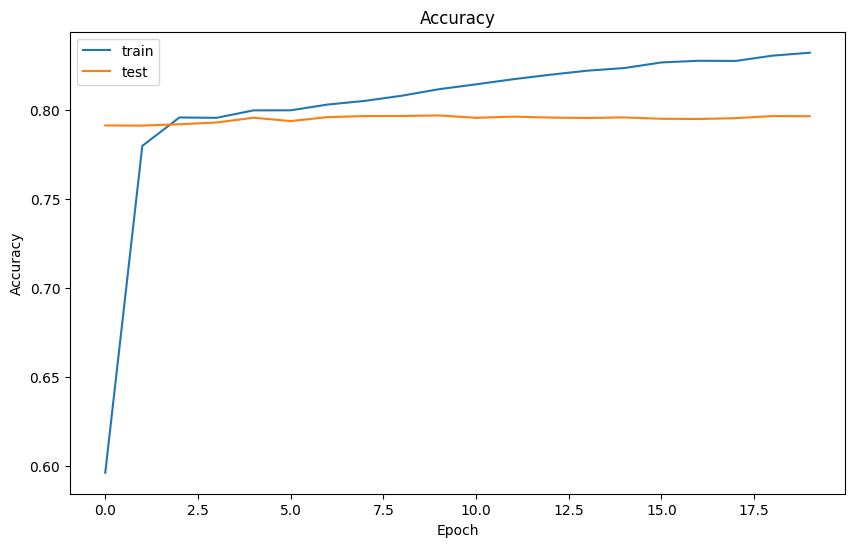

In [77]:
plt.figure(figsize = (10,6))
plt.plot(bi_lstm_rnn.history['accuracy'])
plt.plot(bi_lstm_rnn.history['val_accuracy'])
plt.title('Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train','test'],loc = 'upper left')
plt.show()

In [78]:
score = bi_lstm.evaluate(tmp_x,preproc_english_sentences,verbose = 0)

In [79]:
print("Training Accurancy :",score[1])

Training Accurancy : 0.8341071605682373


In [80]:
x[15]

'வெளிநாட்டுக்கு ஷூட்டிங் கிளம்பும்வரை நன்றாகத்தான் இருந்தார் ஆபிரஹாம்'

In [81]:
y[15]

'before his voyage overseas for shooting he was perfectly alright'

In [82]:
print(logits_to_text(bi_lstm.predict(tmp_x[:25])[15],english_tokenizer))

1/1 [==============================] - 1s 684ms/step
and lived the overseas selvaraghavan shooting the <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [83]:
tmp_x[:25][15]

array([2060, 2061, 2062, 2063,  430, 2064,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)

In [84]:
def user_pad(x,length = max(length_tamil)):
  return pad_sequences(x,maxlen = length,padding = 'post')

In [85]:
def user_prediction(x):
  preprocess_x = tam_tokenizer.texts_to_sequences(x)
  preprocess_x = user_pad(preprocess_x)
  return preprocess_x

In [86]:
print("Enter the Tamil sentence :")
txt = str(input())
processed_tamil = user_prediction([txt])
print("\n",processed_tamil)

print("\nResult for LSTM model :")
print(logits_to_text(lstm.predict(processed_tamil)[0],english_tokenizer))

print("\nResult for Bidirectional LSTM model :")
print(logits_to_text(bi_lstm.predict(processed_tamil)[0],english_tokenizer))

Enter the Tamil sentence :
நீ ஏன் இப்படி இருக்கிறாய்

 [[  94  378  573 4327    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]

Result for LSTM model :
1/1 [==============================] - 0s 356ms/step
then young ravindran swiss <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>

Result for Bi

1/1 [==============================] - 1s 653ms/step
the eu worldwide <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>


In [87]:
test_tamil = tamil_input[10000:10100]
test_english = english_input[10000:10100]

In [88]:
exclude = set(string.punctuation)

In [89]:
for i in range(0,len(test_tamil)):
  test_tamil[i] = test_tamil[i].strip('\n')
  test_tamil[i] = ''.join(ch for ch in test_tamil[i] if ch not in exclude)

In [90]:
def bleu_score_finder(model_prediction,actual_output):
  return sentence_bleu(actual_output,model_prediction,weights = (1,0,0,0))

In [91]:
bleu_sum = 0
for i in range(0,len(test_tamil)):
  processed_tamil = user_prediction([test_tamil[i]])
  predict = (logits_to_text(lstm.predict(processed_tamil)[0],english_tokenizer))
  score = bleu_score_finder(predict,test_english[i])
  bleu_sum += score

print("\nBleu score for LSTM model :",bleu_sum/100)

1/1 [==============================] - 0s 20ms/step


/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.9/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg

1/1 [==============================] - 0s 19ms/step

Bleu score for LSTM model : 0.03523461411237456


In [92]:
bleu_sum = 0
for i in range(0,len(test_tamil)):
  processed_tamil = user_prediction([test_tamil[i]])
  predict = (logits_to_text(bi_lstm.predict(processed_tamil)[0],english_tokenizer))
  score = bleu_score_finder(predict,test_english[i])
  bleu_sum += score

print("\nBleu score for Bidirectional LSTM model :",bleu_sum/100)

1/1 [==============================] - 0s 31ms/step

Bleu score for Bidirectional LSTM model : 0.029019642051874874


#MBart

In [5]:
model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-50-many-to-many-mmt")
tokenizer = MBart50TokenizerFast.from_pretrained("facebook/mbart-large-50-many-to-many-mmt",src_lang = "ta_IN")

In [ ]:
from transformers import MBartForConditionalGeneration, MBartTokenizerFast
from transformers import TrainingArguments, Trainer
from datasets import load_dataset

# Load the pre-trained mBART model and tokenizer
model = MBartForConditionalGeneration.from_pretrained("facebook/mbart-large-cc25")
tokenizer = MBartTokenizerFast.from_pretrained("facebook/mbart-large-cc25")

# Load the Tamil-English parallel data
dataset = load_dataset("csv", data_files={"train": "train.csv", "validation": "val.csv"})

# Tokenize the input text and convert it into numerical data
def tokenize(batch):
    return tokenizer.prepare_seq2seq_batch(batch["text"], return_tensors="pt")

dataset = dataset.map(tokenize, batched=True, batch_size=16, remove_columns=["text"])

# Define the training arguments and trainer
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="steps",
    eval_steps=500,
    save_steps=1000,
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
)

# Fine-tune the model
trainer.train()

In [8]:
print("Enter the Tamil sentence :")
input_text = str(input())
model_inputs = tokenizer(input_text,return_tensors = "pt")
generated_tokens = model.generate(**model_inputs,forced_bos_token_id = tokenizer.lang_code_to_id["en_XX"])

Enter the Tamil sentence :
தமிழ் எழுத்துடன் உரையை தட்டச்சு செய்ய


In [9]:
output_text = tokenizer.batch_decode(generated_tokens,skip_special_tokens = True)[0]
print("Result for MBart model :")
print("\n",output_text)

Result for MBart model :

 To transcribe the speech in Tamil


In [11]:
bleu_sum = 0
for i in range(0,len(test_tamil)):
  model_inputs = tokenizer(test_tamil[i],return_tensors = "pt")
  generated_tokens = model.generate(**model_inputs,forced_bos_token_id = tokenizer.lang_code_to_id["en_XX"])
  output_text = tokenizer.batch_decode(generated_tokens,skip_special_tokens = True)[0]
  score = bleu_score_finder(output_text,test_english[i])
  bleu_sum += score

print("Bleu score for MBart model :",bleu_sum/100)

Bleu score for MBart model :0.8787878
